In [1]:
import subprocess, gc, emoji, re

import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
from transformers import XLMRobertaTokenizer, XLMRobertaConfig, TFXLMRobertaModel, TFXLMRobertaForMaskedLM

In [68]:
def run_command(command):
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE, shell=True)
    return process.communicate()

## Dataset

### Load dataset

In [2]:
df_train_tcn  = pd.read_csv('product-translation-dataset/train_tcn.csv')
df_train_en   = pd.read_csv('product-translation-dataset/train_en.csv')
df_test_tcn   = pd.read_csv('product-translation-dataset/test_tcn.csv')
df_dev_tcn  = pd.read_csv('product-translation-dataset/dev_tcn.csv')
df_dev_en   = pd.read_csv('product-translation-dataset/dev_en.csv')

In [3]:
df_test_tcn.columns = ['product_title', 'split']
df_dev_tcn.columns = ['product_title', 'split']
df_dev_en.columns = ['product_title']

In [4]:
df_all = pd.concat([df_train_tcn, df_train_en,
                    df_test_tcn,
                    df_dev_tcn, df_dev_en]).reset_index().drop(['index',
                                                                'split',
                                                                'category'], axis=1)
df_all.tail()

,product_title
1011995,Hippored Torn Fun Unique Style Straight Jeans ...
1011996,Kids Set Table Bay - Thin Long Sleeve Home Sui...
1011997,LONGCHAMP Le Pliage Neo High Density Nylon Bac...
1011998,IFairies Opening Adjustable Ring ifairies [564...
1011999,PolarStar Women Sweat Quick Dry T-shirt Black ...


In [5]:
df_all = df_all[~((df_all["product_title"].str.contains('\n')) & 
                (df_all["product_title"].str.contains('\"')) & 
                (df_all["product_title"].str.contains(',')))]

In [6]:
df_all = df_all.fillna('')

In [7]:
%%time
p = emoji.get_emoji_regexp()
df_all['product_title'] = [re.sub(p, r"", str(x)) for x in df_all['product_title'].tolist()]

Wall time: 2min 39s


## Model

### Initialize tokenizer

In [8]:
tokenizer = XLMRobertaTokenizer.from_pretrained('jplu/tf-xlm-roberta-base')
special_tokens = [tokenizer.bos_token_id, 
                  tokenizer.eos_token_id, 
                  tokenizer.sep_token_id, 
                  tokenizer.pad_token_id, 
                  tokenizer.cls_token_id,
                  tokenizer.mask_token_id]
special_tokens

[0, 2, 2, 1, 0, 250001]

In [9]:
mask = pd.read_csv('uniq_tokens_masks.csv')['tcn_en_mask'].to_numpy()
for special_token in special_tokens:
    mask[special_token] = 1
enc_mapping = {}
dec_mapping = {}
for i in range(len(mask)):
    if mask[i] == 0:  continue
    enc_mapping[i] = len(enc_mapping)
    dec_mapping[len(dec_mapping)] = i

In [10]:
enc_table = tf.lookup.StaticVocabularyTable(
            tf.lookup.KeyValueTensorInitializer(
                list(enc_mapping.keys()),
                list(enc_mapping.values()),
                key_dtype=tf.int64,
                value_dtype=tf.int64,
            ),
            num_oov_buckets=1,
        )

In [11]:
dec_table = tf.lookup.StaticVocabularyTable(
            tf.lookup.KeyValueTensorInitializer(
                list(dec_mapping.keys()),
                list(dec_mapping.values()),
                key_dtype=tf.int64,
                value_dtype=tf.int64,
            ),
            num_oov_buckets=1,
        )

In [12]:
class CustomTokenizer(XLMRobertaTokenizer):
    def __init__(self, enc_table, dec_table, **kwargs):
        self.enc_table = enc_table
        self.dec_table = dec_table
        super().__init__(**kwargs)
    
    def __call__(self, text, **kwargs):
        res = super().__call__(text, **kwargs)
        res['input_ids'] = tf.cast(enc_table.lookup(tf.cast(res['input_ids'], tf.int64)), tf.int32)
        return res
    def decode(self, token_ids, **kwargs):
        token_ids = tf.cast(dec_table.lookup(tf.cast(token_ids, tf.int64)), tf.int32)
        return super().decode(token_ids, **kwargs)

tokenizer = CustomTokenizer.from_pretrained('jplu/tf-xlm-roberta-base', enc_table=enc_table, dec_table=dec_table)

In [13]:
def calc_tokens(sentences, mask_prob=0.15, mask_id=250001):
    res = tokenizer(sentences,
                    max_length=64,
                    truncation=True,
                    #padding='max_length',
                    padding=True,
                    return_tensors='tf',
                    return_attention_mask=True,
                    return_special_tokens_mask=True)
    input_tokens        = res['input_ids']
    attention_mask      = res['attention_mask']
    special_tokens_mask = res['special_tokens_mask']
    
    mask = tf.cast(tf.random.uniform(shape=tf.shape(input_tokens)) < mask_prob, 'int32') * (1 - special_tokens_mask)
    
    masked_input_tokens = input_tokens * (1-mask) + mask_id * mask
    label_input_tokens  = input_tokens * mask + -100 * (1-mask)
    return masked_input_tokens, label_input_tokens, attention_mask

def generate_data(df_train, batch_size, mask_prob=0.3):
    while True:
        df_train = df_train.sample(frac=1.0)
        for i in range(0, len(df_train)-batch_size, batch_size):
            X, Y, attention_mask = calc_tokens(list(df_train['product_title'].iloc[i:i+batch_size].to_numpy()), mask_prob, enc_mapping[250001])
            yield {'input_ids': X,
                   'labels':Y,
                   'attention_mask': attention_mask}, Y

In [14]:
X_test, Y_test = next(generate_data(df_all, batch_size=1, mask_prob=0.15))

In [15]:
tokenizer.decode(X_test['input_ids'][0])

'<s><mask>唯工<mask> 以<mask>為師 以頸為鑰 以肺為宗 以腎為基<mask></s>'

### Initialize configuration

In [16]:
config = XLMRobertaConfig(vocab_size=44512,
                          hidden_size=256,
                          num_hidden_layers=8,
                          num_attention_heads=4,
                          intermediate_size=1024,
                          hidden_act='gelu',
                          hidden_dropout_prob=0.1,
                          attention_probs_dropout_prob=0.1,
                          max_position_embeddings=68,
                          type_vocab_size=2,
                          initializer_range=0.02,
                          layer_norm_eps=1e-12,
                          gradient_checkpointing=False
                         )

### Build model

In [17]:
input_ids      = tfk.layers.Input(shape=(None,), name='input_ids', dtype='int32')
attention_mask = tfk.layers.Input(shape=(None,), name='attention_mask', dtype='int32')
x = TFXLMRobertaForMaskedLM(config)([input_ids, attention_mask])[0]
model = tfk.models.Model(inputs=[input_ids, attention_mask], outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tfxlm_roberta_for_masked_lm (TF ((None, None, 44512) 17908192    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
Total params: 17,908,192
Trainable params: 17,908,192
Non-trainable params: 0
__________________________________________________________________________________________________


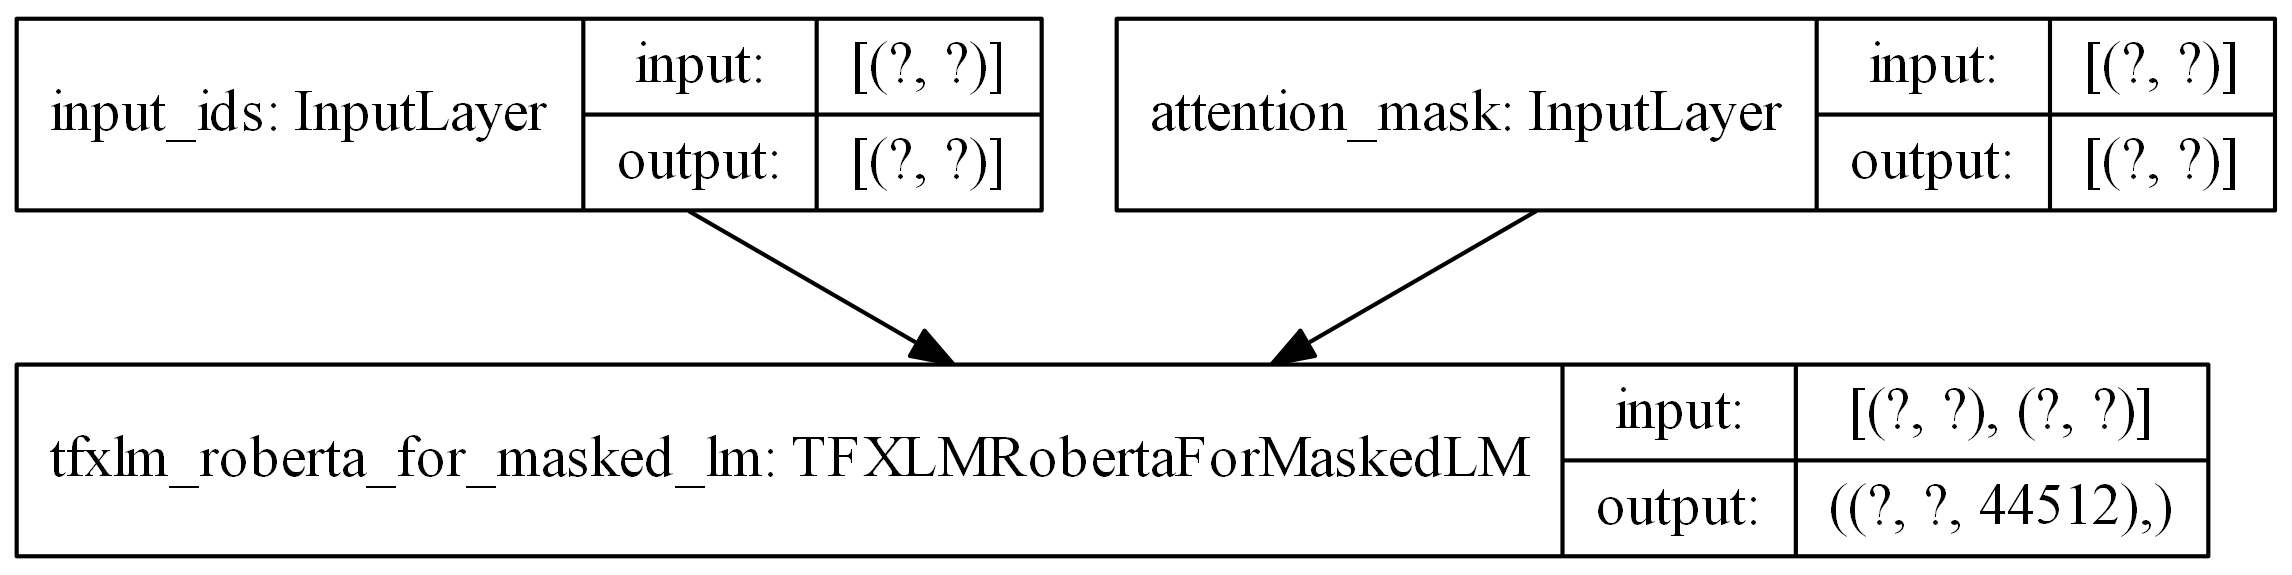

In [18]:
tfk.utils.plot_model(model, show_shapes=True, dpi=300)

In [19]:
def mlm_loss(labels, logits):
    loss_fn = tfk.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE #SUM
    )
    # make sure only labels that are not equal to -100
    # are taken into account as loss
    active_loss = tf.reshape(labels, (-1,)) != -100
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, tf.shape(logits)[2])), active_loss)
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    return loss_fn(labels, reduced_logits)

### Train model

In [53]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(tfk.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = tfk.backend.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        tfk.backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=1e-4,
                                        total_steps=8*120*200,  # 8 hours * 120 epochs/hour * 200 steps/epoch
                                        warmup_learning_rate=1e-7,
                                        warmup_steps=200,
                                        hold_base_rate_steps=200,
                                        global_step_init=200*(17+13*30+3*30+7)
                                       )
            
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=90,
    min_lr=1e-7
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='loss',
    patience=180,
    restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    update_freq=100,
    write_graph=False,
    profile_batch = 0
)

In [21]:
model.compile(optimizer=tfk.optimizers.Adam(),
              loss=mlm_loss)

In [70]:
model.save_weights('tcn-en-model-weights-2/tcn_to_en_model')
run_command("gsutil rm -r gs://shopee-title-translation/models/tcn-en-model-weights-2")
run_command("gsutil cp -r tcn-en-model-weights-2 gs://shopee-title-translation/models")

(b'', None)

In [23]:
df_all['product_title'] = df_all['product_title'].str.lower()

In [54]:
for v in range(0, 50+1):
    print("---------------- {} ----------------".format(v))
    model.fit(generate_data(df_all, batch_size=64, mask_prob=0.15),
              steps_per_epoch=400,
              epochs=60,
              callbacks=[
                reduce_lr,
                early_stop,
                warm_up_lr,
                #tensorboard_callback
              ])
    model.save_weights('tcn-en-model-weights-2/tcn_to_en_model')

---------------- 0 ----------------
Epoch 1/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2565 - lr: 4.5906e-05
Epoch 2/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2593 - lr: 4.5580e-05
Epoch 3/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2739 - lr: 4.5253e-05
Epoch 4/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2446 - lr: 4.4927e-05
Epoch 5/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2529 - lr: 4.4600e-05
Epoch 6/60
400/400 [==============================] - 66s 164ms/step - loss: 3.2331 - lr: 4.4275e-05
Epoch 7/60
400/400 [==============================] - 65s 163ms/step - loss: 3.2813 - lr: 4.3949e-05
Epoch 8/60
400/400 [==============================] - 67s 167ms/step - loss: 3.2289 - lr: 4.3624e-05
Epoch 9/60
308/400 [======================>.......] - ETA: 15s - loss: 3.2463

KeyboardInterrupt: 

In [44]:
X, Y = next(generate_data(df_all, 2, 0.15))
X

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
 array([[    0,     6, 39879,  1714,  4848, 22705,  2772, 32516,  1080,
         15195,  2248,    16, 44509,  5883,     2],
        [    0, 44509, 10342,    40,   485,   229,  4648,   123,     2,
             1,     1,     1,     1,     1,     1]])>,
 'labels': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
 array([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  2118,  -100,  -100],
        [ -100, 22232,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100]])>,
 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])>}

In [45]:
tokenizer.decode(X['input_ids'][0])

'<s> 雷射光源指示器(6*1.5cm)<mask>65</s>'

In [46]:
res = model.predict(X)

In [47]:
res.argmax(axis=2)[0]

array([ 1664,     6, 32009,  3196,  5314,  2780, 12549,   118,   332,
        2585,  1080,    16,  2718,  2460,  1664], dtype=int64)

In [48]:
tokenizer.decode(res.argmax(axis=2)[0])

'】 液晶風板線燈(x45*)#色】'